# Fast Hough Transform

## Решение

Решение было основано на [статье](http://www.jip.ru/2017/294-308-2017.pdf).
Алгоритм FHT реализован для преимущественно-горизонтальных прямых с наклоном вверх.

Для поиска прямых другого типа и применения найденного угла наклона строк предлагается повернуть или отобразить изображение таким образом, чтобы задача состояла в поиске ПГП с наклоном вверх:

```
- ПГП + t > 0: rotate(angle)
- ПГП + t < 0: img[::-1, :]; get angle; img[::-1, :]; rotate(angle)
- ПВП + t < 0: rotate(90); get angle; rotate(-90); rotate(angle)
- ПВП + t > 0: rotate(90); img[::-1, :]; get angle; rotate(90); img[::-1, :]; rotate(angle)
```

<img src="./cases.png " alt="Drawing" style="width: 500px;"/>

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm

import sys
sys.setrecursionlimit(2000)

DATA_PATH = './data/'

In [2]:
def merge_parts(p0, p1):
    h = p0.shape[0]
    w = p0.shape[1] * 2
    A = np.zeros((h, w))
    
    for strip in range(w):
        strip_ = int(strip / 2)
        shift = strip - strip_
        A[:, strip] = p0[:, strip_] + np.concatenate([p1[shift:, strip_], p1[:shift, strip_]], axis = 0)
    return A

    
def fht(img):
    h, w = img.shape
    if w < 2:
        return img[:, 0].reshape((h, 1))
    else:
        mid = w // 2
        return merge_parts(fht(img[:, :mid]), fht(img[:, mid:]))
    
    
def rotate(img, angle):
    h, w = img.shape
    center = (h / 2, w / 2)
    rot = cv2.getRotationMatrix2D(center, angle, 1.0) 
    img = cv2.warpAffine(img, rot, (w, h), flags=cv2.INTER_NEAREST)
    return img
    
    
def get_angle(a, visualize=False):
    h, w = a.shape
    max_var = np.argmin(np.var(a, axis=0))
    mid = w / 2
    angle = - 45 * (max_var - mid) / mid
    
    if visualize:
        plt.figure(figsize=(6, 6))
        plt.title('FHT')
        plt.imshow(a, cmap='gray')
        plt.plot([max_var] * h, np.arange(h), 'y')
        plt.plot([mid] * h, np.arange(h), 'r')
        plt.axis('off')
        plt.show()
        
    return angle

    
def get_all_fht_angles(img):
    h, w = np.array(img).shape
    if w & (w - 1) != 0:
        w_pow = pow(2, np.ceil(np.log(w)/np.log(2)))
        scale = w_pow / w
        img = cv2.resize(img, (int(w_pow), int(scale * h)), cv2.INTER_CUBIC)
        
    img = np.array(img)
    rotated = ndimage.rotate(img, 90)
    return {
        'i': get_angle(fht(img)), 
        'r': get_angle(fht(rotated)), # rotatd
        'm': get_angle(fht(img[::-1, :])), # mirror
        'mr': get_angle(fht(rotated[::-1, :])) # rotated and mirror
    }


### Пример работы алгоритма на простом изображении

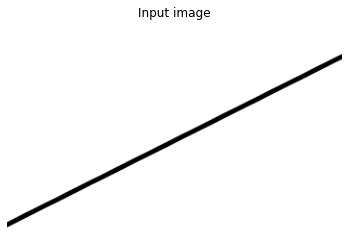

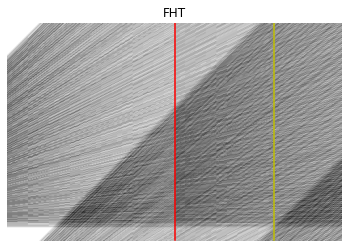

Tilt angle:  -26.71875


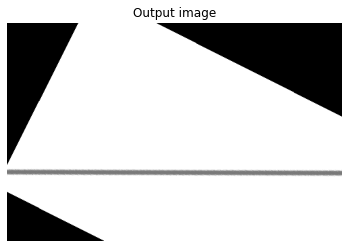

In [3]:
img = cv2.imread(DATA_PATH + '1.png', cv2.IMREAD_GRAYSCALE)
h, w = img.shape

plt.figure(figsize=(6, 6))
plt.title('Input image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

img = cv2.resize(img, (512, int(h * 512 / w)), cv2.INTER_NEAREST)
angle = get_angle(fht(img), True)
print('Tilt angle: ', angle)

img = rotate(img, angle)
plt.figure(figsize=(6, 6))
plt.title('Output image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

### Описание решения

Для получения решения алгоритм запускается для обнаружения всех возможных видом прямых, \
то есть применяется 4 вида преобразования и для каждого находится угол наклона строк. \
Далее среди всех углов выбирается наименьший по модулю. \
Это делается потому, что угол максимальный, когда нужной прямой нет, дисперсии у всех столбцов одинаковые, \
поэтому максимальное значение любое из списка и np.argmax выбирает первый столбец. \
Также, в основном, по наблюдениям угло наклона у изображений небольшой, поэтому выбирается наименьший из найденных.

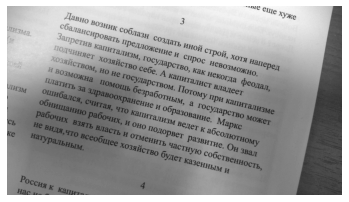

{'i': -43.8134765625, 'r': -44.912109375, 'm': -44.9560546875, 'mr': 9.580078125}


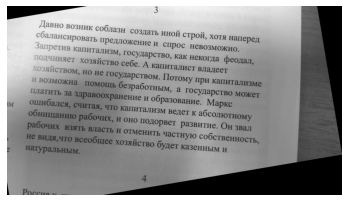

In [4]:
img = cv2.imread(DATA_PATH + '1.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

angles_dict = get_all_fht_angles(img)
print(angles_dict)
min_idx = np.argmin(np.abs(list(angles_dict.values())))
angle = list(angles_dict.values())[min_idx]

img = rotate(img, angle)

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Выводы

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.41it/s]


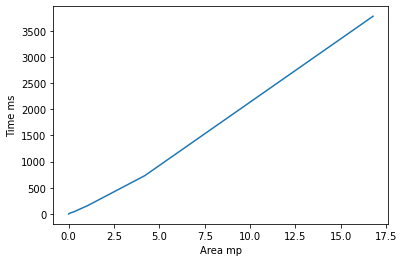

In [5]:
sizes = [(8, 8), (64, 64), (256, 256), (512, 512), (1024, 1024), (2048, 2048), (4096, 4096)]
area_by_time = []

for size in tqdm(sizes):
    img = np.random.uniform(low=0, high=255, size=size)
    start_time = time.time()
    a = fht(img)
    end_time = time.time()
    area_by_time.append((size[0] * size[1] * 1e-6 , (end_time - start_time) * 1e3))
    
area_by_time = np.array(area_by_time)

plt.plot(area_by_time[:, 0], area_by_time[:, 1])
plt.xlabel('Area mp')
plt.ylabel('Time ms')
plt.show()

- суммарная сложность ```O(4*N**2log(N)) -> O(N**2log(N))```
- в качестве оптимизации я бы попровала избавиться от рекурсии, изначально бы посчитала интервалы, а потом их переиспользовала в цикле